In [2]:
import yfinance as yf
import datetime
import numpy as np
from tensorflow import keras
import pandas as pd


#need to create a time period for 2000's - yesterday for out training data
today = datetime.date.today()
yesterday = today - datetime.timedelta(days = 1)

#prompt user for ticker
ticker = input("Enter your ticker: ")
Tickerdata = yf.download(ticker, start = '2005-01-01', end = yesterday) 

#Validates that a ticker has populated the DF
while len(Tickerdata) == 0:
    ticker = input("Invalid Ticker, Please Enter a Valid Ticker: ")
    ticker = ticker.upper()
    Tickerdata = yf.download(ticker, start = '2005-01-01', end = yesterday) 

#prompt for monthly contribution and validates entry is integer
contrib = input("Enter your monthly contribution amount")
while contrib.isdigit() == False:
    contrib = input("Please enter a valid integer for monthly contribution amount")
contrib = int(contrib)

#add daily earnings and next day close feature that can be used as features/targets
Tickerdata["daily_earnings"] = Tickerdata["Close"] - Tickerdata["Open"]
Tickerdata['next_day_close'] = Tickerdata["Close"].shift(-1) # includes the next rows close price, may create an NA due to close price of "today" not being updated
Tickerdata['IDE'] = Tickerdata['next_day_close'] - Tickerdata['Close'][ticker] #intraday earnings


#Add features based on the Date
Tickerdata['Weekday'] = Tickerdata.index.day_of_week
Tickerdata['Month'] = Tickerdata.index.month
Tickerdata['Year'] = Tickerdata.index.year

Tickerdata['Days_Since_Start'] = (Tickerdata.index - Tickerdata.index[0]).days #days since start tracking
Tickerdata['Years_Since_Start'] = Tickerdata['Days_Since_Start']/365
Tickerdata['Log_Close'] = np.log(Tickerdata['Close'])

#Add features based on performance

Tickerdata['SMA_30'] = Tickerdata['Close'].rolling(window = 30).mean()
Tickerdata['SMA_200'] = Tickerdata['Close'].rolling(window = 200).mean() #200 day moving average using the rolling function, will create NANS that we will drop
Tickerdata['SMA_500'] = Tickerdata['Close'].rolling(window = 500).mean()
Tickerdata['volatility'] = Tickerdata['Close'].rolling(window=200).std()


def add_fourier_terms(df, period=252, order = 3):
    t = np.arange(len(df))
    for i in range(1, order + 1):
        df[f'sin_{i}'] = np.sin(2 * np.pi * i * t / period)
        df[f'cos_{i}'] = np.cos(2 * np.pi * i * t / period)
    return df

Tickerdata = add_fourier_terms(Tickerdata, period=252, order=3)
Tickerdata.dropna(inplace=True)





2025-06-15 10:35:07.290138: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-15 10:35:07.292345: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-15 10:35:07.299443: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749976507.311250   96941 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749976507.314841   96941 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-15 10:35:07.327011: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
#Simple Linear Regression Model That will establish a stable long term trend
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

linx = Tickerdata[['Years_Since_Start']]
liny = Tickerdata['Log_Close']

linx_train,linx_test, liny_train,liny_test = train_test_split(linx, liny, test_size= .2, shuffle=False) #do not shuffle for time series data
linreg_model = LinearRegression().fit(linx_train, liny_train)
log_test = linreg_model.predict(linx_test)
price_pred = np.exp(log_test)

In [4]:
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_percentage_error
print("lin model R2: ", r2_score(np.exp(liny_test), price_pred ))

rmse = root_mean_squared_error(np.exp(liny_test), price_pred)
print("RMSE:", rmse)
mape = mean_absolute_percentage_error(np.exp(liny_test), price_pred)
print("MAPE: ",mape*100,"%")



year = Tickerdata['Years_Since_Start'].iloc[-1]

Decade = np.array([[year+10]])

future_log = linreg_model.predict(Decade)

future_price = np.exp(future_log)[0]

print('Future Price Predicted: ',future_price)

current_price = Tickerdata['Close'].iloc[-1][0]

CAGR = (future_price/current_price)**(1/10)  - 1

print('Compound Annual Growth Rate: ', CAGR)

lin model R2:  0.32123704783634854
RMSE: 25.804758178508486
MAPE:  10.94324369834689 %
Future Price Predicted:  2925.864771694925
Compound Annual Growth Rate:  0.3082673176659565


In [5]:
Tickerdata

Price,Close,High,Low,Open,Volume,daily_earnings,next_day_close,IDE,Weekday,Month,...,SMA_30,SMA_200,SMA_500,volatility,sin_1,cos_1,sin_2,cos_2,sin_3,cos_3
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2006-12-26,2.449717,2.481575,2.431084,2.468952,490688800,-0.019235,2.450018,0.000302,1,12,...,2.633628,2.111682,1.760490,0.305101,-0.124344,0.992239,-0.246757,0.969077,-0.365341,0.930874
2006-12-27,2.450018,2.464444,2.307261,2.348735,1935754800,0.101283,2.430482,-0.019536,2,12,...,2.630793,2.113816,1.763488,0.305971,-0.099568,0.995031,-0.198146,0.980172,-0.294755,0.955573
2006-12-28,2.430482,2.441903,2.393816,2.410947,1119876800,0.019535,2.549798,0.119316,3,12,...,2.626656,2.116016,1.766427,0.306660,-0.074730,0.997204,-0.149042,0.988831,-0.222521,0.974928
2006-12-29,2.549798,2.566628,2.505318,2.523050,1076429200,0.026748,2.518542,-0.031256,4,12,...,2.627447,2.119101,1.769588,0.307909,-0.049846,0.998757,-0.099568,0.995031,-0.149042,0.988831
2007-01-03,2.518542,2.602093,2.461439,2.593377,1238319600,-0.074835,2.574442,0.055900,2,1,...,2.625634,2.121977,1.772685,0.308943,-0.024931,0.999689,-0.049846,0.998757,-0.074730,0.997204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-06,203.919998,205.699997,202.050003,203.000000,46607700,0.919998,201.449997,-2.470001,4,6,...,204.513714,224.627017,202.242432,15.954513,0.623490,-0.781831,-0.974928,0.222521,0.900969,0.433884
2025-06-09,201.449997,206.000000,200.020004,204.389999,72862600,-2.940002,202.669998,1.220001,0,6,...,204.261850,224.505684,202.286999,16.038238,0.603804,-0.797133,-0.962624,0.270840,0.930874,0.365341


In [6]:


short_term_features = [    'Weekday', 'Month', 'Open', "Years_Since_Start", "Days_Since_Start", "SMA_200", "SMA_500",'sin_1', 'sin_2', 'sin_3', 'cos_1', 'cos_2', 'cos_3']
x = Tickerdata[short_term_features]
y = Tickerdata['Log_Close'].values.reshape(-1, 1) 

from sklearn.preprocessing import StandardScaler
xscaler = StandardScaler()
yscaler = StandardScaler()
xscale= xscaler.fit_transform(x)
yscale = yscaler.fit_transform(y)

In [7]:
window = int(len(Tickerdata)/2)


def train_lstm(x, y, window):
    x_lstm, y_lstm = [], []
    for i in range(window, len(x)):
        x_lstm.append(x[i-window:i])
        y_lstm.append(y[i]) 
        # creates 30 day chunks one day at a time, overlapping one day at a time until the last day of the dataframe for x to predict the end 30 day chunk of y
    return np.array(x_lstm), np.array(y_lstm)
x_lstm, y_lstm = train_lstm(xscale, yscale, window)

x_train,x_test,y_train,y_test = train_test_split(x_lstm, y_lstm, test_size=.2, shuffle=False)


In [8]:

model = keras.models.Sequential()
model.add(keras.layers.LSTM(128, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2]))) 
#model.add(keras.layers.Dropout(.2))
model.add(keras.layers.LSTM(128, return_sequences=True )) 
#model.add(keras.layers.Dropout(.2))

model.add(keras.layers.LSTM(128, return_sequences=False )) 
#model.add(keras.layers.Dropout(.2))

#model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer = 'adam', metrics=['mean_absolute_percentage_error'])
model.summary()

2025-06-15 10:35:11.837528: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/eduard/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 2322, 128)      │        72,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 2322, 128)      │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 336,001 (1.28 MB)

 Trainable params: 336,001 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
import tensorflow as tf
hist = model.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=.3, verbose=1,callbacks =
                
    [tf.keras.callbacks.EarlyStopping(
    monitor = 'val_mean_absolute_percentage_error', mode = 'min',
    patience = 10,
    restore_best_weights = True
    )])

Epoch 1/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - loss: 0.1068 - mean_absolute_percentage_error: 71.2855 - val_loss: 0.0096 - val_mean_absolute_percentage_error: 6.0042
Epoch 2/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - loss: 0.0075 - mean_absolute_percentage_error: 33.0406 - val_loss: 0.0084 - val_mean_absolute_percentage_error: 6.0972
Epoch 3/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - loss: 0.0043 - mean_absolute_percentage_error: 24.0605 - val_loss: 0.0112 - val_mean_absolute_percentage_error: 7.2741
Epoch 4/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - loss: 0.0030 - mean_absolute_percentage_error: 18.7461 - val_loss: 0.0033 - val_mean_absolute_percentage_error: 3.5139
Epoch 5/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - loss: 0.0026 - mean_absolute_percentage_error: 18.8004 - val_loss: 0.0024 - val_mean_absolute_percentage_error: 3.0293


15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 700ms/step


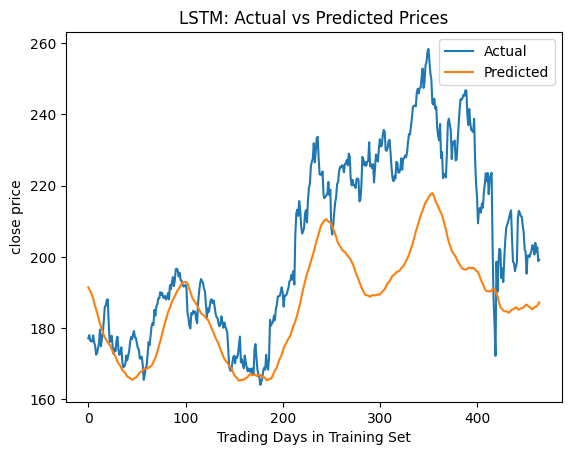

RMSE: 25.804758178508486
R2:  0.22727554000123795
MAPE: 8.071433929547828 %


In [10]:
y_pred = model.predict(x_test)
y_pred_real = yscaler.inverse_transform(y_pred)
y_test_real = yscaler.inverse_transform(y_test.reshape(-1, 1))
import matplotlib.pyplot as plt
plt.plot(np.exp(y_test_real), label='Actual')
plt.plot(np.exp(y_pred_real), label='Predicted')
plt.title("LSTM: Actual vs Predicted Prices")
plt.legend()
plt.xlabel('Trading Days in Training Set')
plt.ylabel('close price')
plt.show()

LSTM_rmse = root_mean_squared_error(np.exp(y_test_real),np.exp(y_pred_real))
LSTM_r2 = r2_score(np.exp(y_test_real),np.exp(y_pred_real))
LSTM_mape = mean_absolute_percentage_error(np.exp(y_test_real),np.exp(y_pred_real))

print(f"RMSE:" ,rmse)   

print(f"R2: ", LSTM_r2)
print('MAPE:', LSTM_mape*100,"%")

In [11]:
Tickerdata['Close'].iloc[-1]

Ticker
AAPL    199.199997
Name: 2025-06-12 00:00:00, dtype: float64

In [ ]:

lookback_days = 252*5  #approx 5 yrs of trading
recent_data = Tickerdata.iloc[-lookback_days:]

# Calculate actual CAGR
start_price = recent_data['Close'].iloc[0]
end_price = recent_data['Close'].iloc[-1]
years = (recent_data.index[-1] - recent_data.index[0]).days / 365

cagr = (end_price / start_price) ** (1 / years) - 1
log_cagr = np.log(1 + cagr)

### Setting a Trend 

We need to set a trend for our forecast, if we do not do that our forecasted data will hover around the same prices (the more recent prices collected during the window, which is why we also set a very wide window during the train-test-split). We are going to set a trend based on the Compound Annual Growth Rate (CAGR) of our ticker for the past 5 years of its history, this way the trend can be organic to each ticker.

For the Code below, we are attempting to create a loop that will forecast the price of our ticker 10 years into the future using the predict method. We will need to first feed it recent values, since our SMA_500 requires the largest amount of data, we will give it a dataset of the past 500 days. Forecasting features will be the same as our prediction features (reason I have two different variables is because I at one point experimented with trying different feature sets for forecasting and model training). 

Our forecast loop will need to loop over 2520 TRADING DAYS, so we will need to add a feature to skip weekends, reshape our data into an array again to feed into our LSTM predictor (just like we did above) 

In [ ]:
from datetime import timedelta
import numpy as np


#We need a list of opening prices that our forecasting will work on
pricehist = Tickerdata['Open'].iloc[:,0]
pricehist = pricehist.iloc[-500:]
pricehist = pd.Series(pricehist)
pricehist = list(pricehist)

forecast_features = [
                    'Weekday', 'Month', 'Open', "Years_Since_Start", "Days_Since_Start", "SMA_200", "SMA_500","volatility", 'sin_1', 'sin_2', 'sin_4', 'cos_1', 'cos_2', 'cos_4'
    ]


window = 252
forecast_days = 2520

#use some of our old data
feature_hist = xscale[-window:] 

last_day_count = Tickerdata['Days_Since_Start'].iloc[-1]
total_years = Tickerdata['Years_Since_Start'].iloc[-1]
date = Tickerdata.index[-1]
SMA_200 = np.mean(pricehist[-200:])
SMA_500=  np.mean(pricehist[-500:])


future_dates = []
pred_log = []
pred_price = []


#create a daily trend variable to add a trend to the data 



for i in range(forecast_days):
    #NEED this if statement, otherwise our first day dramatically trends downward on the first forecasted day, we will just append the last close price & not do anything else
    if i == 0:
        date += timedelta(days=1)
        while date.weekday() > 4:
            date += timedelta(days=1)

        log_real = np.log(Tickerdata['Close'].iloc[-1])
        log_real_trend = log_real # no trend on day 1
        pred_log.append(log_real)
        pred_price.append(np.exp(log_real_trend))
        future_dates.append(date)  
        continue
    #skip non trading days
    date += timedelta(days=1)
    while date.weekday() > 4:
        date += timedelta(days=1) 

    #pricehist = Tickerdata['Open'].iloc[-500:]
    # Reshape our data for LSTM
    LSTM_input = feature_hist.reshape(1, window, -1)
    #Predict on our data
    log_scaled = model.predict(LSTM_input)[0, 0]
    

    #transform our target
    log_real = yscaler.inverse_transform([[log_scaled]])[0, 0]
    
    #adding our CAGR Trend
    log_real_trend = log_real + log_cagr * i / 252
    pred_log.append(log_real)


    #exponentiate to list of predictions in dollars
    price = float(np.exp(log_real_trend))#cast to float to avoid error
    pred_price.append(price)
    pricehist.append(price)
    pricehist = pricehist[-500:]

    #redefine these features to be used meaningfully inside our loop
    SMA_200 = np.mean(pricehist[-200:])
    SMA_500=  np.mean(pricehist[-500:])
    volatility = np.std(pricehist[-200:])
    #append next trading day to 
    future_dates.append(date)
    # 3. Generate next row using predicted price as "Open"
    year = total_years + (i+1) / 252
    new_row = {
        'Weekday':date.weekday(),
        'Month': date.month,
        'Open': price,
        'Year': date.year,
        'Years_Since_Start': year,
        'Days_Since_Start': last_day_count + i + 1,   
        'SMA_200':SMA_200,
        'SMA_500':SMA_500,
        'volatility':volatility
    }

    t = len(Tickerdata) + i + 1
    for j in range(1, 4):
        new_row[f'sin_{j}'] = np.sin(2 * np.pi * j * t / 252)
        new_row[f'cos_{j}'] = np.cos(2 * np.pi * j * t / 252)
    #create array of features
    new_vals = np.array([[new_row[feat] for feat in forecast_features]])
    #scale the new vals
    new_scaled = xscaler.transform(new_vals)

    #  Update window
    feature_hist = np.vstack([feature_hist, new_scaled])[-window:]



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━

In [15]:
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Log_Close_Pred': pred_log,
    'Close_Pred': pred_price
}).set_index('Date')
LSTM_final = forecast_df['Close_Pred'].iloc[-1]
LSTM_final

1298.4235996196949

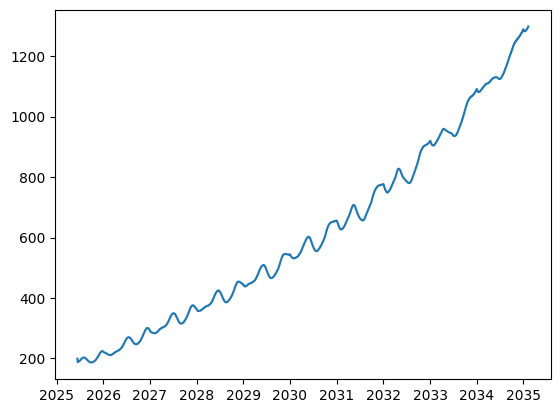

In [16]:

forecast_df

plt.plot(forecast_df['Close_Pred'])
plt.show()

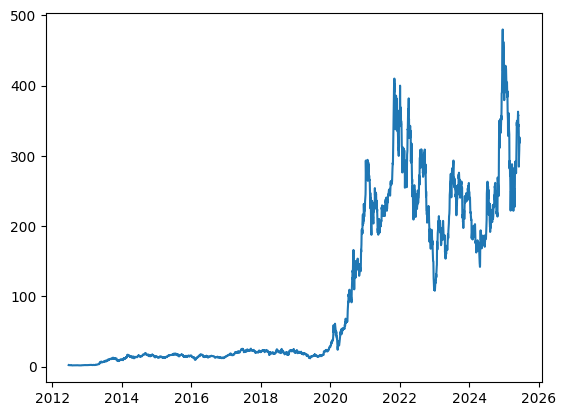

In [ ]:
plt.plot(Tickerdata['Close'])
plt.show()

In [ ]:
forecast_df

,Log_Close_Pred,Close_Pred
Date,,
2025-06-13,Ticker TSLA 5.765536 Name: 2025-06-12 00:00...,Ticker TSLA 319.109985 Name: 2025-06-12 00:...
2025-06-16,5.75909,317.468343
2025-06-17,5.760489,318.322692
2025-06-18,5.762386,319.338346
2025-06-19,5.764612,320.462808
...,...,...
2035-02-02,5.352489,5393.327998
2035-02-05,5.352652,5401.159152
2035-02-06,5.352861,5409.255862
